# **Image Scaling attack**

this notebook shows an example of an image scaling attack on the test data set using our CNN. 

# Setup Environmet  

feel free to skip this step

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/CompVision Assignment 2/data"

/content/drive/.shortcut-targets-by-id/1JSKuo1EgGmXoyTyFH7bLmh4QyZejsXhh/CompVision Assignment 2/data


In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Nadam, Adam

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%load_ext tensorboard
import time

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Found GPU at: /device:GPU:0


# Load & Transform data

In [77]:
# Load test data 
test = pd.read_csv("test.csv")

In [6]:
def transform_test(data):
  """
  transform array so it can be read by the model
  """
    image_array = np.zeros(shape=(len(data), 48, 48, 1))

    for i in data.index:
        image = np.fromstring(data.pixels.loc[i], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48,1)) 
        # Normalize to be between 0 -> 1
        image_array[i] = image / 255

    return image_array

# **image scaling attack**

In [78]:
img_test = transform_test(test)

# Source Image

(48, 48, 1)


[0.03715803 0.00084562 0.13790847 0.02382916 0.54794294 0.00497558
 0.24734023]
Sad


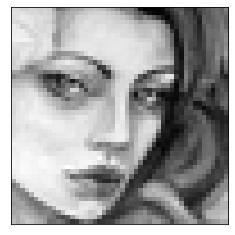

In [229]:
from tensorflow.keras.models import load_model 
import imageio as io

# load model 
model = load_model("best.h5")

# index of source image
index = 7

print(img_test[index].shape)

img = img_test[index]

prediction = model.predict(img_test)


img_pred = prediction[index]

print(img_pred)

# 1-hot encoding to label
label = img_pred.argmax(0)

emotions = ["Angry","Disgust","Fear","Happy","Sad","Suprise","Neutral"]



#pot image and save it for attack

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img_test[index,:,:,0], cmap='binary_r')
print(emotions[label])
io.imwrite("sad.png", img_test[index,:, :, 0]) 

# Target Image

[0.33222643 0.00906152 0.2651687  0.00796405 0.32615682 0.00846135
 0.05096114]
Angry


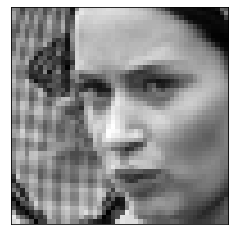

In [217]:
# same as for source image

index = 12

img_pred = prediction[index]

print(img_pred)

label = img_pred.argmax(0)

emotions = ["Angry","Disgust","Fear","Happy","Sad","Suprise","Neutral"]

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img_test[index,:,:,0], cmap='binary_r')
print(emotions[label])
io.imwrite("sad_attack.png", img_test[index,:, :, 0]) 

# Attack Image

[[0.31886154 0.00966935 0.2640744  0.01022375 0.33259365 0.00933063
  0.0552467 ]]
4
Sad


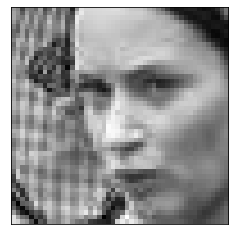

In [231]:
# same as for source image
# with addition load image from drive instead from the test array

from PIL import Image
import numpy as np
img = Image.open("attack_image.jpg").convert('L')
arr = np.array(img.getdata(), dtype=np.uint8) # Note the dtype input
arr = np.reshape(arr, (48, 48,1))
arr = arr/255

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(arr[:,:,0], cmap='binary_r')

arr = np.reshape(arr, (1,48, 48,1))
prediction = model.predict(arr)

prediction_img = prediction[0]
print(prediction)

emotions = ["Angry","Disgust","Fear","Happy","Sad","Suprise","Neutral"]
label = prediction_img.argmax(0)
print(label)

print(emotions[label])

# Image Scaling attack: 
Algorithm Source Code from: https://github.com/ReyanAdil/Image_Scaling_Attack



In [ ]:
# CODE STOLEN 

from PIL import Image

source_image = Image
target_image = Image
try:
    # Source Image
    source_image = Image.open("sad.png")
    source_image = source_image.convert('RGB').split()
    # Target Image
    target_image = Image.open("sad_attack.png")
    target_image = target_image.convert('RGB').split()
except IOError:
    print("File Not Found")
implement_attack(source_image, target_image)

In [125]:
# CODE STOLEN 


import numpy as np
from PIL import Image
import cvxpy as cp
import cv2


def get_coefficients(m, n, mprime, nprime, scale_func=Image.NEAREST):  # def get_coefficients(int, int, int, int)
    # set image size and scaled image size, here image size is m*n = 700*350 and scaled m'*n' = 175*50
    In_max = 255  # maximum pixel value in an image/white

    # now we will create an identity matrix of size m*m, and multiply it with the highest pixel value ie white
    # so basically we are creating a white box of size m*m, lets call it 'matrix_of_white_box'

    # its more like a white diagonal in a black box

    matrix_of_white_box = np.identity(m) * In_max  # this creates a 2d array with all white values, hence a white box

    # now we will scale this white box down to the scaling size of m*m' using the scaling algo

    # for that we need to convert this 'matrix_of_white_box' into an image first, hence:
    white_box = Image.fromarray(matrix_of_white_box.T)
    # now we scale it using 'resize'
    resized_white_box = white_box.resize((mprime, m), scale_func)

    # now the CL or the vertical coefficient matrix will be this 'resized_white_box' converted to array and then divided
    # by the In_max value, which now just leaves the fractions, which are the coefficients for this scaling
    # i.e. m'*m
    CL = np.array(resized_white_box).T / In_max  # transposing because white_box is (175, 700) but CL is (700, 175)

    # we need to do the same for CR
    # create matrix_of_white_box
    matrix_of_white_box = np.identity(n) * In_max

    # convert matrix to image
    white_box = Image.fromarray(matrix_of_white_box.T)

    # scale the image to n*n'
    resized_white_box = white_box.resize((n, nprime), scale_func)

    # convert this image to array and divide by In_max so we are left with coefficients
    CR = np.array(resized_white_box).T / In_max

    return CL, CR


def generate_attack_image(source_image, target_image, scale_func=Image.NEAREST):
    # S
    source_image_array = np.array(source_image)

    # T
    target_image_array = np.array(target_image)

    m, n = source_image_array.shape  # m = height of S image, n = width of S image
    mprime, nprime = target_image_array.shape  # m' = height of T image, n' = width of T

    # get coefficient matrices
    CL, CR = get_coefficients(m, n, mprime, nprime, scale_func)

    print(m, n, mprime, nprime, CL.shape, CR.shape)

    # create empty delta_one_vertical matrix filled with zeroes of size m*n'
    delta_one_vertical = np.zeros((m, nprime))

    # get intermediate_source_image of size mxn'
    intermediate_source_image = source_image.resize((m, nprime), scale_func)
    intermediate_source_image_array = np.array(intermediate_source_image).T  # convert image to array
    # Launch vertical scaling attack
    for col in range(nprime):
        delta_one_vertical[:, col] = get_perturbation(intermediate_source_image_array[:, col],
                                                      target_image_array[:, col], CL, obj='min')

    # intermediate attack image of size mxn', achieved by adding delta_one_vertical and intermediate_source_image
    intermediate_attack_image_array = (intermediate_source_image_array + delta_one_vertical).astype('uint8')

    # create delta_one_horizontal matrix filled with zeros of size m*n
    delta_one_horizontal = np.zeros((m, n))

    # Launch horizontal attack
    for row in range(m):
        delta_one_horizontal[row, :] = get_perturbation(source_image_array[row, :],
                                                        intermediate_attack_image_array[row, :], CR, obj='min')
    # get final attack_image_array
    attack_image_array = (source_image_array + delta_one_horizontal).astype('uint8')

    attack_image = Image.fromarray(attack_image_array)

    return attack_image


# I tried to make this method universal
# 1: It Maximizes or Minimizes the objective function depending on the value of 'obj' = min/max
# 2: It toggles constraints based on convert_matrix.size, because we need to match matrices for successful dot product
# def get_perturbation(np.1dArray, np.1dArray, np.2dArray, String):
def get_perturbation(source_vector, target_vector, convert_matrix, obj):
    n = source_vector.size

    # Declare variable named 'perturb' to optimize. It is a 1d array/vector of size same as source_vector
    # perturb is basically delta1 in 1dimension
    # This method is where all the magic happens so read the details below to understand
    # 1. perturb(or delta1) is an array/vector that can assume a lot of possible elements while being of size n
    #    Further multiple sets(arrays) of n size can satisfy perturb
    # 2. This method computes all the possible elements and sets that perturb can have or be while maintaining some rules
    # 3. Rule a: Each element of (perturb when added with source_vector) should remain between 0 and 255(allowed pixel)
    #    Rule b: delta2 should be bounded by(less than) 0.01*255
    #            This kinda denotes that the difference between target image and output image should not exceed this value
    #            delta2 = CL(perturb + source_vector) - target_vector; since attack_vector = CL*(perturb + source_vector)
    #    Rule c: As we know that there could be multiple sets of perturb that could satisfy Rule a and b, therefore we
    #            find the Lsquare norm(which is basically squareroot of(sum of squares of all elements of perturb).
    #            In a way it gives the magnitude of an array/vector, our job is to find the set that has the min/max
    #            Lsquare Norm off all the possible sets
    perturb = cp.Variable(n)

    # Create the function to be Maximised/Minimised (||delta1||2 --> L^2 norm of delta1)
    function = cp.norm(perturb)

    # Declare objective function based on value of obj
    if obj == 'max':
        objective = cp.Maximize(function)  # Rule c
    else:
        objective = cp.Minimize(function)  # Rule c

    constraints = []
    # set up constraints
    # Rule a:
    constraints += [source_vector + perturb >= 0]
    constraints += [source_vector + perturb <= 255]

    # Rule b:
    # if the number of columns of convert_matrix coincide with the number of rows of source_vector(when its column vector)
    if convert_matrix[0].size == source_vector.size:
        constraints += [cp.norm_inf((convert_matrix * (source_vector + perturb)) - target_vector) <= (0.01 * 255)]
    else:  # else Transpose convert_matrix to make them coincide (usually happens when source_vector is a row vector)
        constraints += [cp.norm_inf((convert_matrix.T * (source_vector + perturb)) - target_vector) <= (0.01 * 255)]

    # Create problem with objective and constraints
    prob = cp.Problem(objective, constraints)

    # Launch the solver
    prob.solve()

    # Testing:
    print(prob.status)
    print(perturb.value.shape)

    # Solution array/vector is stored in the value field of perturb
    return perturb.value


def implement_attack(source_image, target_image):   # def implement_attack(Image, Image)

    # Convert(to drop Alpha channel if any) and Split Source image into separate channels(stored as tuple)
    #source_image = source_image.split()

    # Convert(to drop Alpha channel if any) and Split Target image into separate channels(stored as tuple)
    #target_image = target_image.split()

    # store scaling function in a variable scale_func, we can toggle between different scaling functions to be used
    # directly from here, below are some examples
    scale_func = Image.NEAREST

    # generate attack image channels R, G and B
    # We could use a for loop and remove some clutter but this just makes it easy to understand
    R = generate_attack_image(source_image[0], target_image[0])
    G = generate_attack_image(source_image[1], target_image[1])
    B = generate_attack_image(source_image[2], target_image[2])

    # merge the three channels to form the attack image
    attack_image = Image.merge('RGB', (R, G, B))

    # testing: show generated image and scaled image
    attack_image.show()
    attack_image.resize(target_image[0].size, scale_func).show()

    # save the generated attack image
    attack_image.save("attack_image.jpg")